In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import src.data.ToyData as ToyData
import src.models as models
import src.Trainer as Trainer
import src.SDESolver as SDESolver
import src.SDE as SDE
from src.plot import plot_trajectory_2d
import matplotlib.pyplot as plt


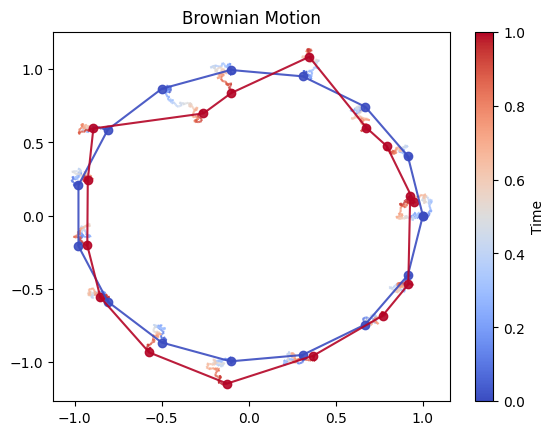

(5, 101, 16, 2)
(5, 16, 2)


100%|██████████| 10000/10000 [01:55<00:00, 86.89it/s]


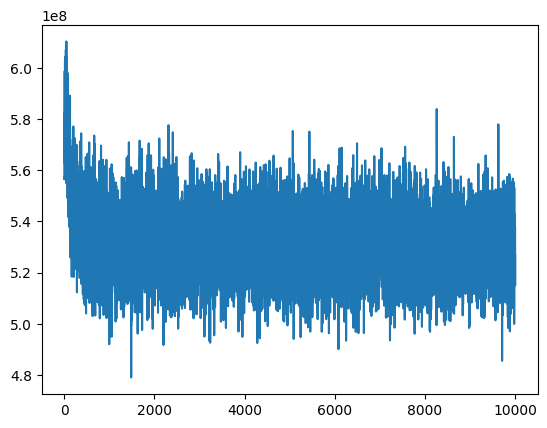

In [2]:


data_generator = ToyData.CircleDataGenerator(landmark_num=16, radius=1, center=jnp.array([0, 0]), seed=43)
trainer = Trainer.SsmTrainer(seed=42)
model = models.DsmModel(dim=2, hidden_dims=(64, 128, 64), with_x0=True)
brownian_sde = SDE.Brownian_Motion_SDE(dim=2, sigma=0.1)
x_0 = data_generator.generate_data(jrandom.PRNGKey(0), 5)
sde_solver = SDESolver.EulerMaruyama.from_sde(brownian_sde, 0.01, 1, 16, 2, jrandom.PRNGKey(0))
xs, diffusions = jax.vmap(sde_solver.solve, in_axes=(0, None))(x_0, jrandom.PRNGKey(0))
plot_trajectory_2d(xs[0], "Brownian Motion", simplified=False)
print(xs.shape)
print(x_0.shape)
train_state = trainer.train_state_init(model, lr=1e-3, model_kwargs={'x': x_0[0], 't': jnp.array([0]), 'x0': x_0[0]})
train_state, losses = trainer.train(train_state, brownian_sde, sde_solver, data_generator, 10000, 5)
plt.plot(losses)
plt.show()


(1, 16, 2)
(16, 2)


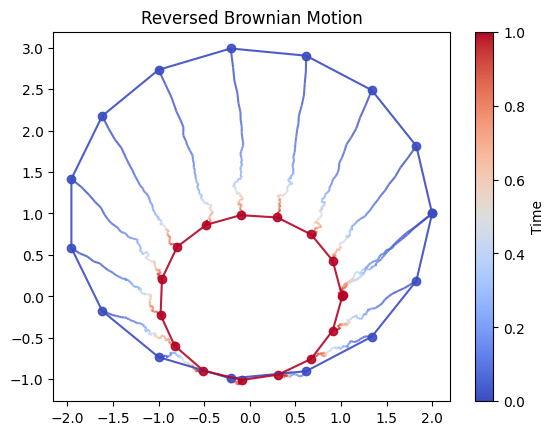

In [8]:
score_fn = lambda x, t, x0: train_state.apply_fn(train_state.params, x, t, x0=x0)
data_generator = ToyData.CircleDataGenerator(landmark_num=16, radius=2, center=jnp.array([0, 1]), seed=44)
xt = data_generator.generate_data(jrandom.PRNGKey(0), 1)
print(xt.shape)
print(x_0[0].shape)
reversed_sde = SDE.Time_Reversed_SDE(brownian_sde, score_fn, 1, 0.01)
reversed_sde_solver = SDESolver.EulerMaruyama.from_sde(reversed_sde, 0.01, 1, 16, 2, jrandom.PRNGKey(0), condition_x=x_0[0])
xs, _ = reversed_sde_solver.solve(xt[1], jrandom.PRNGKey(0))
plot_trajectory_2d(xs, "Reversed Brownian Motion", simplified=False)